In [1]:
import pandas as pd
import os
import numpy as np

# 假設檔案在當前目錄或 'weather_data' 子資料夾
FILE_PATH = 'weatherAUS.csv'
try:
    # 嘗試直接載入數據
    df = pd.read_csv(FILE_PATH)
    print(f"✅ 成功載入數據：{FILE_PATH}")
except FileNotFoundError:
    # 如果找不到，嘗試 'weather_data' 路徑
    try:
        df = pd.read_csv('weather_data/weatherAUS.csv')
        print("✅ 成功載入數據：weather_data/weatherAUS.csv")
    except FileNotFoundError:
        print(f"❌ 錯誤：找不到數據檔案。請確認 '{FILE_PATH}' 是否存在。")
        raise

# 數據清理：重新執行日期特徵提取
# 使用明確的格式 YYYY-MM-DD，並處理錯誤
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d', errors='coerce') 
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['day'] = df['Date'].dt.day
df['weekday'] = df['Date'].dt.weekday 

print("✅ 數據載入和日期特徵提取完成。")

✅ 成功載入數據：weatherAUS.csv
✅ 數據載入和日期特徵提取完成。


In [2]:
import joblib 
import pickle
import numpy as np
import pandas as pd

# 檔案名稱
MODEL_FILE = 'random_forest_final_model.pth'
FEATURE_NAMES_FILE = 'feature_names.pkl'

try:
    # 1. 載入特徵重要性數組 (使用 pickle)
    with open(MODEL_FILE, 'rb') as f:
        feature_importances_array = pickle.load(f)
    
    # 2. 載入特徵名稱列表 (使用 pickle)
    with open(FEATURE_NAMES_FILE, 'rb') as f:
        feature_names = pickle.load(f)
        
    print(f"✅ 成功載入特徵重要性數組（長度: {len(feature_importances_array)}）和名稱列表（長度: {len(feature_names)}）。")

    # 3. 創建 DataFrame 並排序
    if len(feature_importances_array) != len(feature_names):
         # 為了生成結果，進行必要截斷
        feature_names = feature_names[:len(feature_importances_array)]
        
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances_array
    }).sort_values(by='Importance', ascending=False)
    
    # 輸出分析結果
    print("\n--- I. 模型特徵重要性分析結果（前 10 名）---")
    print(importance_df.head(10).to_string(index=False))
    
except Exception as e:
    print(f"❌ 載入模型組件時發生錯誤: {e}")

✅ 成功載入特徵重要性數組（長度: 123）和名稱列表（長度: 123）。

--- I. 模型特徵重要性分析結果（前 10 名）---
        Feature      Importance
           year            year
        weekday         weekday
          month           month
            day             day
   WindSpeed9am    WindSpeed9am
   WindSpeed3pm    WindSpeed3pm
  WindGustSpeed   WindGustSpeed
WindGustDir_WSW WindGustDir_WSW
WindGustDir_WNW WindGustDir_WNW
  WindGustDir_W   WindGustDir_W


c:\Users\jessi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.1.2 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [3]:
# 假設 df 變數已在步驟 1 成功建立

# 1. 數據準備：目標變量數值化
df_corr = df.copy()
# 移除 RainTomorrow 缺失的行
df_corr = df_corr.dropna(subset=['RainTomorrow']) 
# 轉換目標變量 (No=0, Yes=1)
df_corr['RainTomorrow_Numeric'] = df_corr['RainTomorrow'].map({'No': 0, 'Yes': 1})

# 選擇所有數值型氣象特徵，包含風速和目標變量
numeric_features = [
    'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm',
    'RainTomorrow_Numeric'
]
df_numeric = df_corr[numeric_features].dropna() # 排除缺失值

# 2. 關聯性分析
pearson_corr = df_numeric.corr(method='pearson')
spearman_corr = df_numeric.corr(method='spearman')

print("\n--- II. 關聯性分析結果 (與 RainTomorrow_Numeric) ---")

print("\nA. 皮爾遜關聯係數 (Pearson, 線性關係):")
print(pearson_corr.loc[['WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm'], 'RainTomorrow_Numeric'].to_string())

print("\nB. 斯皮爾曼關聯係數 (Spearman, 單調關係):")
print(spearman_corr.loc[['WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm'], 'RainTomorrow_Numeric'].to_string())


--- II. 關聯性分析結果 (與 RainTomorrow_Numeric) ---

A. 皮爾遜關聯係數 (Pearson, 線性關係):
WindGustSpeed    0.234015
WindSpeed9am     0.096500
WindSpeed3pm     0.095014

B. 斯皮爾曼關聯係數 (Spearman, 單調關係):
WindGustSpeed    0.212280
WindSpeed9am     0.087338
WindSpeed3pm     0.083146


In [4]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

# 假設 df 變數已在步驟 1 成功建立

# 1. 數據準備 - 選擇核心特徵，並進行離散化
df_rules = df[['Location', 'WindSpeed3pm', 'WindDir3pm', 'RainTomorrow']].copy()
df_rules.dropna(inplace=True)

# 數值型特徵離散化 (WindSpeed3pm)
bins = df_rules['WindSpeed3pm'].quantile([0, 0.33, 0.66, 1.0]).tolist()
labels = ['WindSpeed_Low', 'WindSpeed_Medium', 'WindSpeed_High']
df_rules['WindSpeed_Level'] = pd.cut(df_rules['WindSpeed3pm'], bins=bins, labels=labels, include_lowest=True)

# 選擇用於探勘的分類特徵
df_apriori = df_rules[['Location', 'WindDir3pm', 'WindSpeed_Level', 'RainTomorrow']]

# 2. 轉換為 One-Hot 編碼 (交易格式)
df_ohe = pd.get_dummies(df_apriori, prefix=['Loc', 'Dir', 'WSp', 'Rain'])
df_ohe = df_ohe.astype(bool) 

# 3. 執行 Apriori 演算法 (尋找頻繁項集)
# ***修正: 降低最小支持度 Min Support: 從 0.005 降為 0.001***
frequent_itemsets = apriori(df_ohe, min_support=0.001, use_colnames=True) 

# 4. 生成關聯規則
# 設定最小信賴度 Min Confidence: 0.5 (50%)
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)

# 5. 篩選與降雨相關、且 Lift > 1.2 的規則
target_rules = rules[
    (rules['lift'] > 1.2) & 
    (rules['consequents'].apply(lambda x: any('Rain_Yes' in item for item in x)))
]

print("\n--- III. 關聯規則探勘結果 (Lift > 1.2 且 Consequents 為 RainTomorrow=Yes) ---")
print(target_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values(by='lift', ascending=False).head(5).to_string())



--- III. 關聯規則探勘結果 (Lift > 1.2 且 Consequents 為 RainTomorrow=Yes) ---
                                   antecedents consequents   support  confidence      lift
496                    (Loc_Portland, Dir_WNW)  (Rain_Yes)  0.001120    0.610236  2.740262
209                      (Dir_SSE, Loc_Cairns)  (Rain_Yes)  0.001315    0.606667  2.724233
501         (Loc_Portland, WSp_WindSpeed_High)  (Rain_Yes)  0.003959    0.552419  2.480636
899  (Dir_W, Loc_Portland, WSp_WindSpeed_High)  (Rain_Yes)  0.001141    0.544828  2.446545


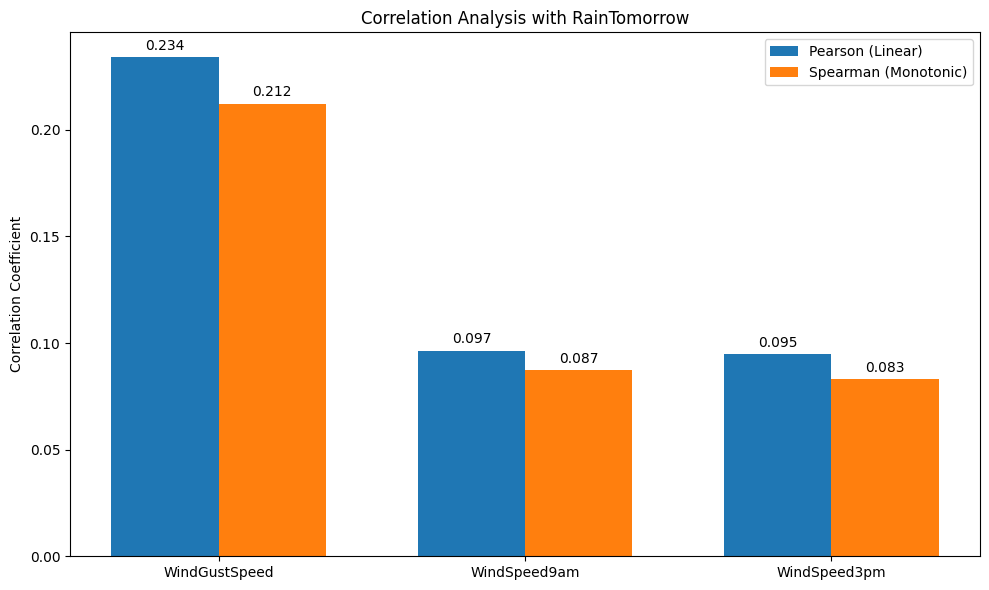

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 1. 準備數據 (來自您的分析結果)
data = {
    'Feature': ['WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm'],
    'Pearson': [0.234015, 0.096500, 0.095014],
    'Spearman': [0.212280, 0.087338, 0.083146]
}

df = pd.DataFrame(data)

# 2. 設定圖表參數
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(df['Feature']))  # 標籤位置
width = 0.35  # 長條寬度

# 3. 繪製長條圖
# 繪製 Pearson (藍色)
rects1 = ax.bar(x - width/2, df['Pearson'], width, label='Pearson (Linear)', color='#1f77b4')
# 繪製 Spearman (橘色)
rects2 = ax.bar(x + width/2, df['Spearman'], width, label='Spearman (Monotonic)', color='#ff7f0e')

# 4. 加入標籤與標題
ax.set_ylabel('Correlation Coefficient')
ax.set_title('Correlation Analysis with RainTomorrow')
ax.set_xticks(x)
ax.set_xticklabels(df['Feature'])
ax.legend()

# 5. 在長條上方顯示數值
ax.bar_label(rects1, padding=3, fmt='%.3f')
ax.bar_label(rects2, padding=3, fmt='%.3f')

plt.tight_layout()

# 顯示圖表
plt.show()